In [1]:
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import sys
from pathlib import Path
sys.path.append(Path('../src'))
from src.molecular_hamiltonian import Molecular_Hamiltonian
from src.bf_quantum_state import BFQuantumState
import src.constants

First we compute the ground states and ground state energies and store them for later use.

In [2]:
molecules = ['H2', 'LiH', 'H2O', 'NH3']
for molecule in molecules:
    save_direc_eigs = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_eigenvalues_first.npy')
    save_direc_groundstate = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_groundstate_dict.npy')
    energy_eig_vals, eigvecs = Molecular_Hamiltonian(molecule).diagonalize(1, True)
    ground_state = pt.tensor(eigvecs[:, 0])
    np.save(save_direc_eigs, energy_eig_vals)
    np.save(save_direc_groundstate, ground_state)

Now we do shadow measurements on our ground state and store them to later predict the energy.

In [4]:
molecules = ['H2', 'LiH']
num_of_measurements = 7000000
measurement_methods = np.array(['derandomized', 'randomized'])
for molecule in molecules:
    print('starting molecule ' + molecule)
    save_direc_groundstate = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_groundstate_dict.npy')
    ground_state = pt.tensor(np.load(save_direc_groundstate, allow_pickle=True), dtype=src.constants.DEFAULT_COMPLEX_TYPE)
    for l in range(0, 2):
        observables = Molecular_Hamiltonian(molecule).observables_for_energy_estimation()
        measurement_procedure, measurement_index = BFQuantumState(Molecular_Hamiltonian(molecule).qubit_number_after_jordan_wigner(),
                            ground_state).measurement_shadow(num_of_measurements, measurement_methods[l], observables)
        save_direc_procedure = Path('data/shadow_measurements/procedure_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
        save_direc_index = Path('data/shadow_measurements/index_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
        np.save(save_direc_procedure, measurement_procedure)
        np.save(save_direc_index, measurement_index)

starting molecule H2
starting molecule LiH


In [2]:
# this function converts the stored measurement outcomes to the correct shape needed for the shadow prediction
def conversion_to_prediction_shadow_dict_shape(measurement_procedure, measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    measurement = np.dstack((measurement_procedure, np.array(measurement_array, dtype=int)))
    return measurement

In [6]:
measurement_methods = np.array(['derandomized', 'randomized'])
num_of_measurements = 10000
molecules = ['LiH']
energies_shadow = []
energies_brute = []
for molecule in molecules:
    for l in range(0,1):
        save_direc_procedure = Path('data/shadow_measurements/procedure_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
        save_direc_index = Path('data/shadow_measurements/index_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
        measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
        measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
        measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[0:num_of_measurements,:],
                                                                  measurement_index[0:num_of_measurements], Molecular_Hamiltonian(molecule).qubit_number_after_jordan_wigner())
        energy_shadow = Molecular_Hamiltonian(molecule).energy_shadow(measurements)
        save_direc_eigs = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_eigenvalues_first.npy')
        energy_brute = np.load(save_direc_eigs, allow_pickle=True)
        energies_shadow.append(energy_shadow)
        energies_brute.append(energy_brute)
        print('exact energie of molecule ' + molecule + ' = ' + str(energy_brute))
        print('energie estimated with ' + measurement_methods[l] + ' shadows of molecule ' + molecule + ' = ' + str(energy_shadow))
        print('relative error: ' + str(np.abs((energy_brute - energy_shadow) / energy_brute)))

exact energie of molecule LiH = [-7.8827622]
energie estimated with derandomized shadows of molecule LiH = (-7.843476716910967+0j)
relative error: [0.00498372]


Now we plot the relative error in the prediction of the energy $\frac{|E_{exact} - E_{shadow}|}{E_{exact}}$ against the number of measurements.

In [6]:
measurement_methods = np.array(['derandomized', 'randomized'])
numbers_of_measurements = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 10**6, 2*10**6, 7*10**6])
batches = 1
molecules = ['H2', 'LiH']
try:
    save_direc_rel_errors = Path('data/energy_estimations/molecules_relative_erros_in_energy_prediction_dict.npy')
    all_rel_errors = np.load(save_direc_rel_errors, allow_pickle=True)
    all_rel_errors = all_rel_errors.item()
except:
    all_rel_errors = {}
for molecule in molecules:
    all_rel_errors[molecule] = {}
    save_direc_eigs = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_eigenvalues_first.npy')
    energy_brute = float(np.load(save_direc_eigs, allow_pickle=True))
    for l in range(0,2):
        rel_errors_in_one_batch = np.zeros((np.size(numbers_of_measurements), batches))
        for b in range(0, batches):
            for n in range(0, np.size(numbers_of_measurements)):
                save_direc_procedure = Path('data/shadow_measurements/procedure_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
                save_direc_index = Path('data/shadow_measurements/index_molecule_' + molecule +'_method_'+measurement_methods[l]+'.npy')
                measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
                measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
                measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[b*numbers_of_measurements[n]:(b+1)*numbers_of_measurements[n],:],
                                                                          measurement_index[b*numbers_of_measurements[n]:(b+1)*numbers_of_measurements[n]], Molecular_Hamiltonian(molecule).qubit_number_after_jordan_wigner())
                energy_shadow = float(Molecular_Hamiltonian(molecule).energy_shadow(measurements).real)
                rel_errors_in_one_batch[n,b] = np.abs(energy_shadow - energy_brute) / np.abs(energy_brute)
        all_rel_errors[molecule][measurement_methods[l]] = rel_errors_in_one_batch
save_direc_rel_errors = Path('data/energy_estimations/molecules_relative_erros_in_energy_prediction_dict.npy')
np.save(save_direc_rel_errors, all_rel_errors)

[0.03213004 0.03261112 0.01491722 0.00519562 0.00425021 0.00417502
 0.004397   0.00428023 0.00438171 0.00447262 0.00451166 0.00451326]


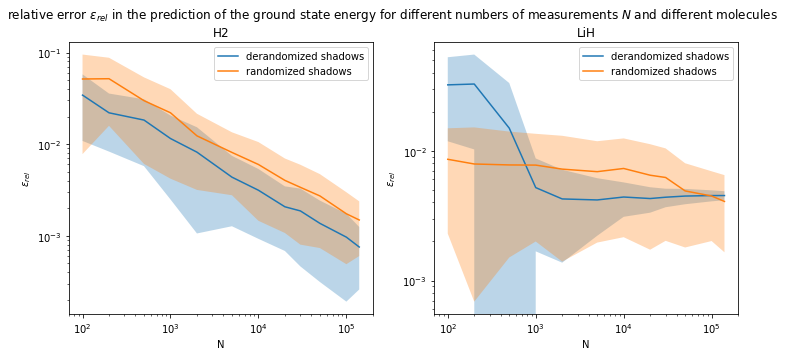

In [14]:
measurement_methods = np.array(['derandomized', 'randomized'])
numbers_of_measurements = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 30000, 50000, 100000, 140000])
molecules = ['H2', 'LiH']
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(12)
fig.suptitle('relative error $\epsilon_{rel}$ in the prediction of the ground state energy for different numbers of measurements $N$ and different molecules')
save_direc_rel_errors = Path('data/energy_estimations/molecules_relative_erros_in_energy_prediction_dict.npy')
all_rel_errors_dict = np.load(save_direc_rel_errors, allow_pickle=True)
all_rel_errors_dict = all_rel_errors_dict.item()
for molecule in molecules:
    for l in range(0,2):
        rel_errors = all_rel_errors_dict[molecule][measurement_methods[l]]
        rel_errors_mean = np.mean(rel_errors, axis = 1)
        rel_errors_std = np.std(rel_errors, axis = 1)
        if molecule == 'H2':
            i = 0
            j = 0
        if molecule == 'LiH':
            i = 0
            j = 1
        if molecule == 'H2O':
            i = 1
            j = 0
        if molecule == 'NH3':
            i = 1
            j = 1
        axs[j].errorbar(numbers_of_measurements, rel_errors_mean, label = measurement_methods[l] + ' shadows')
        axs[j].fill_between(numbers_of_measurements, rel_errors_mean - rel_errors_std, rel_errors_mean + rel_errors_std, alpha = 0.3)
        axs[j].set(xscale = 'log', xlabel = 'N', ylabel = '$\epsilon_{rel}$', yscale = 'log')
        axs[j].set_title(molecule)
        axs[j].legend()

rel_errors = all_rel_errors_dict['LiH']['derandomized']
rel_errors_mean = np.mean(rel_errors, axis = 1)
print(rel_errors_mean)

Now we estimate the energy using direct measurements. Later on we will compare the two approaches.

In [19]:
def conversion_to_measurement_outcome_shape(measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    return measurement_array

In [40]:
molecules = ['H2']
numbers_of_measurements_for_each_observable = np.array([10, 20, 50, 100, 150, 200, 500, 700, 1000])
batches = 50
for molecule in molecules:
    observables_array_shape, coefficients = Molecular_Hamiltonian(molecule).observables_and_coefficients_for_energy_estimation()
    save_direc_groundstate = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_groundstate_dict.npy')
    ground_state = pt.tensor(np.load(save_direc_groundstate, allow_pickle=True), dtype=src.constants.DEFAULT_COMPLEX_TYPE)
    save_direc_eigs = Path('data/Diagonal_hamiltonian/molecule_'+ molecule + '_eigenvalues_first.npy')
    energy_brute = float(np.load(save_direc_eigs, allow_pickle=True))
    errors = np.zeros((batches, np.size(numbers_of_measurements_for_each_observable)))
    for k in range(0, batches):
        for j in range(0, np.size(numbers_of_measurements_for_each_observable)):
            errors_all_observables= np.array([])
            energy = 0
            for o in range(0, np.size(observables_array_shape)):
                observable_dict_shape = {}
                if not observables_array_shape[o]:
                    energy = energy + coefficients[o]
                    continue
                for pauli_observable in observables_array_shape[o]:
                    observable_dict_shape[pauli_observable[1]] = str(pauli_observable[0])
                measurement_index, prob = BFQuantumState(Molecular_Hamiltonian(molecule).qubit_number_after_jordan_wigner(), ground_state).measure_pauli(observable_dict_shape, numbers_of_measurements_for_each_observable[j])
                measurement_arrays = conversion_to_measurement_outcome_shape(measurement_index, Molecular_Hamiltonian(molecule).qubit_number_after_jordan_wigner())
                measurement_outcome = 0
                for i in range(0, int(prob.size(dim=0))):
                    measurement_outcome_one_meas = 1
                    for pauli_observable in observables_array_shape[o]:
                        measurement_outcome_one_meas = measurement_outcome_one_meas * measurement_arrays[i][pauli_observable[1]]
                    measurement_outcome = measurement_outcome + prob[i] * measurement_outcome_one_meas
# until here we just obtained the measurement outcome of an arbitrary pauli observable array, now we estimate the energy from this
                energy = energy + coefficients[o] * measurement_outcome
            errors[k,j] = np.abs(energy_brute - energy) / np.abs(energy_brute)

C:\Users\Lenna\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


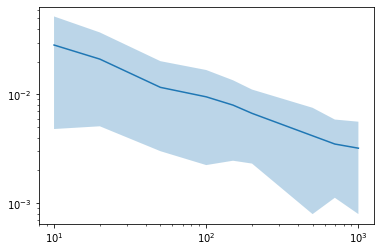

In [43]:
error_mean = np.mean(errors, axis=0)
error_std = np.std(errors, axis = 0)
plt.yscale('log')
plt.xscale('log')
plt.plot(numbers_of_measurements_for_each_observable, error_mean)
plt.fill_between(numbers_of_measurements_for_each_observable, error_mean - error_std, error_mean + error_std, alpha = 0.3)

In [46]:
obs, coeff = Molecular_Hamiltonian('LiH').observables_and_coefficients_for_energy_estimation()
#print(obs)
#print(coeff)
indices = np.where(np.isclose(coeff, 0.00451326*7.882762201008295*2, rtol = 0.05))
for index in indices[0]:
    print(index)
    print(obs[index])

453
[['Z', 2], ['Z', 7]]
455
[['Z', 2], ['Z', 9]]
521
[['Z', 3], ['Z', 6]]
523
[['Z', 3], ['Z', 8]]
566
[['Z', 4], ['Z', 7]]
568
[['Z', 4], ['Z', 9]]
592
[['Z', 5], ['Z', 6]]
594
[['Z', 5], ['Z', 8]]
609
[['Z', 6], ['Z', 9]]
613
[['Z', 7], ['Z', 8]]


In [48]:
for j in range(0, len(obs)):
    if len(obs[j]) == 2:
        print(obs[j])
        print(j)

[['X', 0], ['X', 1]]
11
[['X', 0], ['Y', 1]]
22
[['X', 0], ['X', 2]]
86
[['Y', 0], ['X', 1]]
99
[['Y', 0], ['Y', 1]]
110
[['Y', 0], ['Y', 2]]
174
[['Z', 0], ['Z', 1]]
184
[['Z', 0], ['Z', 2]]
189
[['Z', 0], ['Z', 3]]
194
[['Z', 0], ['Z', 4]]
197
[['Z', 0], ['Z', 5]]
200
[['Z', 0], ['Z', 6]]
201
[['Z', 0], ['Z', 7]]
202
[['Z', 0], ['Z', 8]]
203
[['Z', 0], ['Z', 9]]
204
[['X', 1], ['X', 2]]
214
[['X', 1], ['Y', 2]]
222
[['X', 1], ['X', 3]]
267
[['Y', 1], ['X', 2]]
277
[['Y', 1], ['Y', 2]]
285
[['Y', 1], ['Y', 3]]
330
[['Z', 1], ['Z', 2]]
338
[['Z', 1], ['Z', 3]]
343
[['Z', 1], ['Z', 4]]
346
[['Z', 1], ['Z', 5]]
349
[['Z', 1], ['Z', 6]]
350
[['Z', 1], ['Z', 7]]
351
[['Z', 1], ['Z', 8]]
352
[['Z', 1], ['Z', 9]]
353
[['X', 2], ['X', 3]]
361
[['X', 2], ['Y', 3]]
367
[['X', 2], ['X', 4]]
396
[['Y', 2], ['X', 3]]
403
[['Y', 2], ['Y', 3]]
409
[['Y', 2], ['Y', 4]]
438
[['Z', 2], ['Z', 3]]
445
[['Z', 2], ['Z', 4]]
448
[['Z', 2], ['Z', 5]]
451
[['Z', 2], ['Z', 6]]
452
[['Z', 2], ['Z', 7]]
453
[['Z

In [24]:
save_direc_eigs = Path('data/Diagonal_hamiltonian/molecule_LiH_eigenvalues_first.npy')
energy_brute = float(np.load(save_direc_eigs, allow_pickle=True))
print(energy_brute)

-7.882762201008248


In [27]:
0.00451326*7.882762201008295

0.0355769553313227

In [32]:
len(coeff)

631

In [33]:
coeff[506]

(0.03438035307532428+0j)

In [36]:
for i in range(0, len(obs)):
    if not obs[i]:
        print(i, coeff[i])

0 (-4.119235884549492+0j)
628 (-0.392094223086279+0j)
629 (0.11383952541276207+0j)
630 (-0.39209422308627895+0j)
